In [ ]:
# Approach 1 ..Trainng simple linear regression Model

Initial Data:
shape: (5, 36)
┌──────┬───────┬─────┬─────────────┬───┬───────────────────┬──────────────────┬───────────────────┬─────────────────┐
│ YEAR ┆ MONTH ┆ DAY ┆ DAY_OF_WEEK ┆ … ┆ AVG_AIRPORT_DELAY ┆ AVG_FLIGHT_DELAY ┆ HOURLY_DEPARTURES ┆ HOURLY_ARRIVALS │
│ ---  ┆ ---   ┆ --- ┆ ---         ┆   ┆ ---               ┆ ---              ┆ ---               ┆ ---             │
│ i64  ┆ i64   ┆ i64 ┆ i64         ┆   ┆ f64               ┆ f64              ┆ i64               ┆ i64             │
╞══════╪═══════╪═════╪═════════════╪═══╪═══════════════════╪══════════════════╪═══════════════════╪═════════════════╡
│ 2015 ┆ 10    ┆ 2   ┆ 5           ┆ … ┆ 0.808846          ┆ 0.838239         ┆ 130               ┆ 15              │
│ 2015 ┆ 1     ┆ 20  ┆ 2           ┆ … ┆ 0.920637          ┆ 0.521591         ┆ 1865              ┆ 8               │
│ 2015 ┆ 4     ┆ 21  ┆ 2           ┆ … ┆ 0.925535          ┆ 0.740039         ┆ 183               ┆ 70              │
│ 2015 ┆ 7     ┆ 24  ┆ 5   

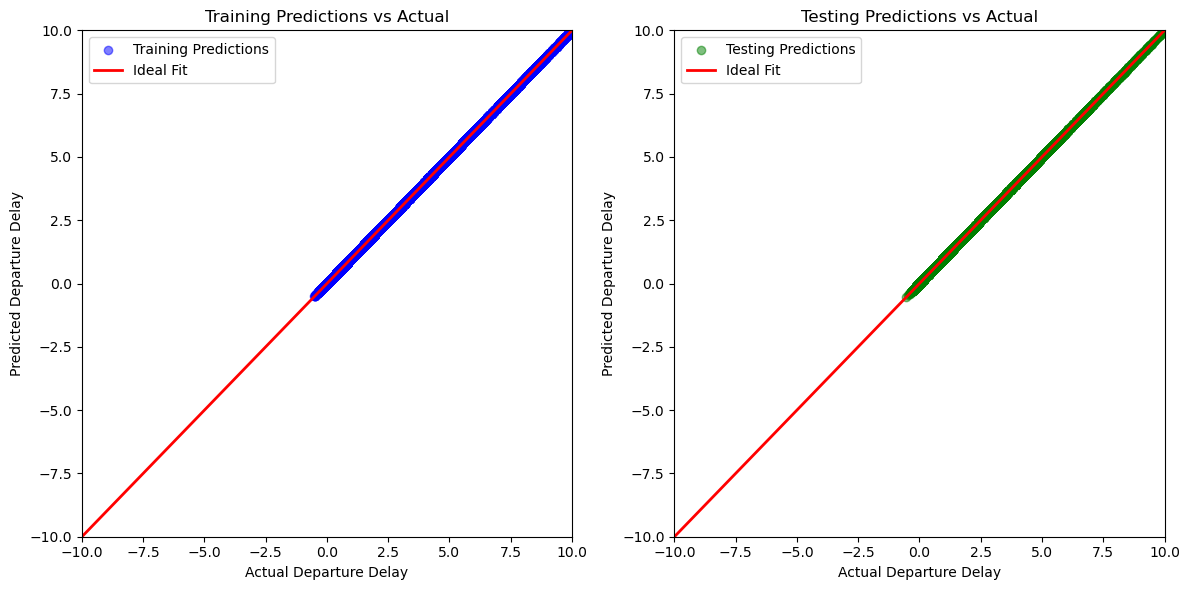

In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the dataset using Polars
df = pl.read_csv('flights_feture.csv')

# Display the initial DataFrame
print("Initial Data:")
print(df.head())

# Handle missing values in numerical columns
num_cols = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 
            'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'TAXI_OUT', 
            'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 
            'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 
            'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 
            'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
            'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DEPARTURE_HOUR', 
            'AVG_AIRLINE_DELAY', 'AVG_AIRPORT_DELAY', 'AVG_FLIGHT_DELAY', 
            'HOURLY_DEPARTURES', 'HOURLY_ARRIVALS']

df = df.with_columns([
    pl.col(col).fill_null(pl.col(col).mean()).alias(col) for col in num_cols
])

# Handle missing values in categorical columns
encoded_cols = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                'DIVERTED', 'CANCELLED', 'SEASON']

df = df.with_columns([
    pl.col(col).fill_null(pl.col(col).median()).alias(col) for col in encoded_cols
])

# Check for any remaining missing values in the DataFrame
print("Missing Values After Imputation:")
print(df.null_count())

# Separate features and target variable
X = df.select(pl.all().exclude("DEPARTURE_DELAY"))  # Exclude target variable
y = df["DEPARTURE_DELAY"].to_numpy()  # Convert to NumPy array

# Check for NaN values in the target variable
if np.isnan(y).any():
    print("Warning: Target variable contains NaN values. Handling them...")
    # Impute missing values in y with the mean
    y = np.where(np.isnan(y), np.nanmean(y), y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2, random_state=42)

# Scale the features data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a simple model (Linear Regression)
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_scaled)
r2 = r2_score(y_test, y_pred_scaled)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

plt.figure(figsize=(12, 6))

# Plot for training predictions
plt.subplot(1, 2, 1)
plt.scatter(y_train, model.predict(X_train_scaled), color='blue', alpha=0.5, label='Training Predictions')
plt.plot([-10, 10], [-10, 10], color='red', linewidth=2, label='Ideal Fit')  # Diagonal line
plt.title('Training Predictions vs Actual')
plt.xlabel('Actual Departure Delay')
plt.ylabel('Predicted Departure Delay')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()  # Add legend

# Plot for test predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_scaled, color='green', alpha=0.5, label='Testing Predictions')
plt.plot([-10, 10], [-10, 10], color='red', linewidth=2, label='Ideal Fit')  # Diagonal line
plt.title('Testing Predictions vs Actual')
plt.xlabel('Actual Departure Delay')
plt.ylabel('Predicted Departure Delay')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()  # Add legend

plt.tight_layout()
plt.show()